# Ex3 - Part 1

## Denoising Autoencoder and Classifier

In [1]:
%matplotlib inline

import helper
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Consts

In [2]:
CIFAR_10_DATASET_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
CIFAR_10_DATASET_FOLDER_PATH = 'cifar-10-batches-py'
TAR_GZ_PATH = 'cifar-10-python.tar.gz'

NOISE_FACTOR = 5
N_BATCHES = 5

### Hyperparameters

In [3]:
epochs = 100
batch_size = 2000
learning_rate = 0.001
show_images_every_n_epochs = 5
keep_probability = 0.8

### Build the networks

In [4]:
def unpool(value, name='unpool'):
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, tf.zeros_like(out)], i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

#### Denoiser

In [5]:
# inputs
inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3))
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3))
labels_ = tf.placeholder(tf.float32, [None, 10])

# encoder
encoder = tf.layers.conv2d(inputs_, 12, [5, 5], strides=(1, 1), padding="SAME")
encoder = tf.layers.max_pooling2d(encoder, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder = tf.layers.conv2d(encoder, 48, [5, 5], strides=(1, 1), padding="SAME")
encoder = tf.layers.max_pooling2d(encoder, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder = tf.layers.conv2d(encoder, 192, [5, 5], strides=(4, 4), padding="SAME")

# decoder
decoder = tf.layers.conv2d_transpose(encoder, 192, [5, 5], strides=(4, 4), padding="SAME")
decoder = unpool(decoder)
decoder = tf.layers.conv2d_transpose(decoder, 48, [5, 5], strides=(1, 1), padding="SAME")
decoder = unpool(decoder)
decoder = tf.layers.conv2d_transpose(decoder, 3, [5, 5], strides=(1, 1), padding="SAME")

# denoiser
y_pred = tf.identity(decoder)
cost = tf.reduce_mean(tf.abs(y_pred - targets_))
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#### Classifier

In [6]:
# inputs
keep_prob = tf.placeholder(tf.float32)

# classifier
classifier = tf.contrib.layers.flatten(encoder)
classifier = tf.layers.dense(classifier, 768, activation=tf.nn.relu)
classifier = tf.nn.dropout(classifier, keep_prob)
classifier = tf.layers.dense(classifier, 384, activation=tf.nn.relu)
classifier = tf.nn.dropout(classifier, keep_prob)
classifier = tf.layers.dense(classifier, 192, activation=tf.nn.relu)
classifier = tf.nn.dropout(classifier, keep_prob)
logits = tf.add(tf.matmul(classifier, 
                          tf.Variable(tf.truncated_normal([classifier.shape[1].value, 10], stddev=0.1))),
                tf.Variable(tf.zeros([10])))

logits = tf.identity(logits)
classifier_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
classifier_opt = tf.train.AdamOptimizer(learning_rate).minimize(classifier_cost)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Denoising autoencoder

### Prepare the dataset

In [7]:
helper.download_dataset(CIFAR_10_DATASET_URL, CIFAR_10_DATASET_FOLDER_PATH, TAR_GZ_PATH) 
helper.preprocess_and_save_data(CIFAR_10_DATASET_FOLDER_PATH, NOISE_FACTOR, N_BATCHES)
    
images, _ = helper.load_cfar10_batch(CIFAR_10_DATASET_FOLDER_PATH, random.randint(1, N_BATCHES))
valid_features, valid_noisy, valid_labels = helper.load_preprocess_validation()[:10]
test_features, test_noisy, test_labels = helper.load_preprocess_testing()

Cifar-10 dataset found
Preprocessing data...
Finished preprocessing


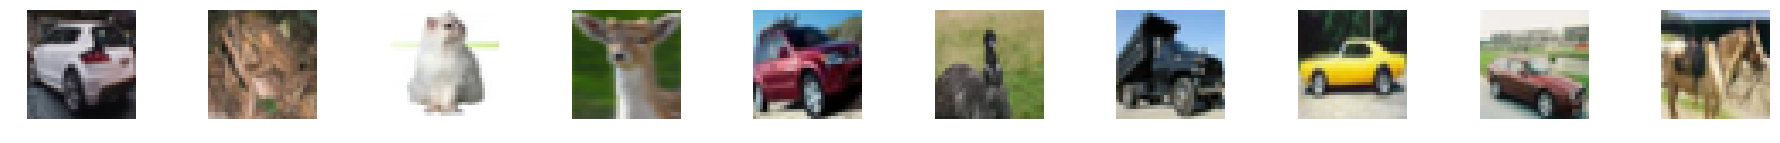

In [8]:
plt.figure(figsize=(32, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(images[i + random.randint(0, len(images) - 10)])

### Train the denoiser

In [9]:
sess = tf.Session()

Training...
('Epoch: 1/100...', 'Training loss: 0.1600')
('Epoch: 2/100...', 'Training loss: 0.1113')
('Epoch: 3/100...', 'Training loss: 0.0933')
('Epoch: 4/100...', 'Training loss: 0.0862')
('Epoch: 5/100...', 'Training loss: 0.0805')
('Epoch: 6/100...', 'Training loss: 0.0749')
('Epoch: 7/100...', 'Training loss: 0.0727')
('Epoch: 8/100...', 'Training loss: 0.0687')
('Epoch: 9/100...', 'Training loss: 0.0665')
('Epoch: 10/100...', 'Training loss: 0.0647')
('Epoch: 11/100...', 'Training loss: 0.0624')
('Epoch: 12/100...', 'Training loss: 0.0604')
('Epoch: 13/100...', 'Training loss: 0.0590')
('Epoch: 14/100...', 'Training loss: 0.0577')
('Epoch: 15/100...', 'Training loss: 0.0575')
('Epoch: 16/100...', 'Training loss: 0.0562')
('Epoch: 17/100...', 'Training loss: 0.0553')
('Epoch: 18/100...', 'Training loss: 0.0535')
('Epoch: 19/100...', 'Training loss: 0.0534')
('Epoch: 20/100...', 'Training loss: 0.0513')
('Epoch: 21/100...', 'Training loss: 0.0504')
('Epoch: 22/100...', 'Training 

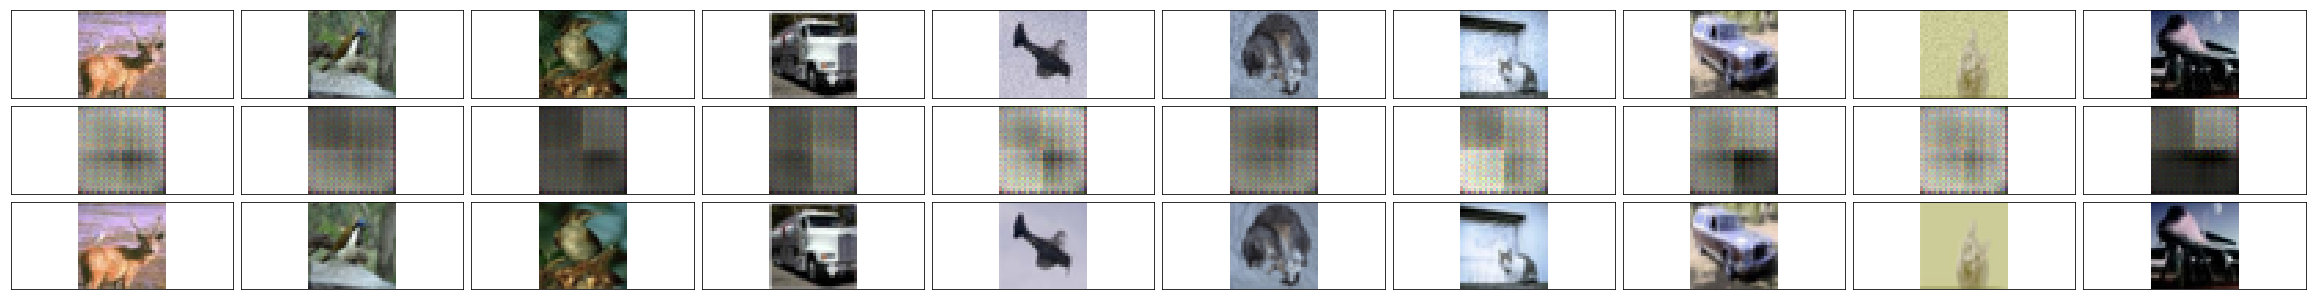

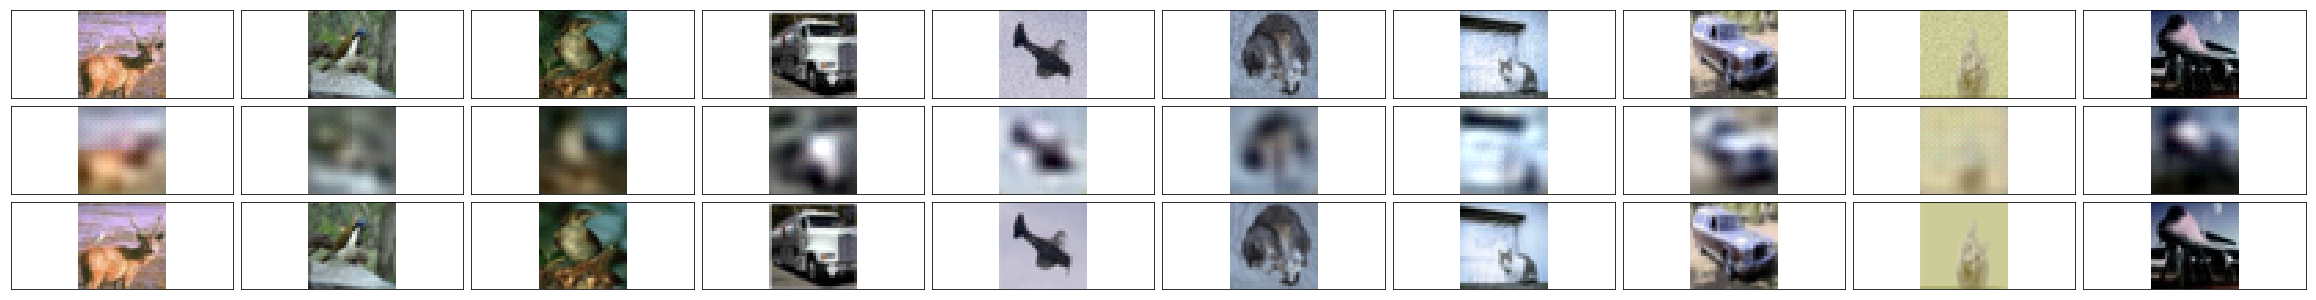

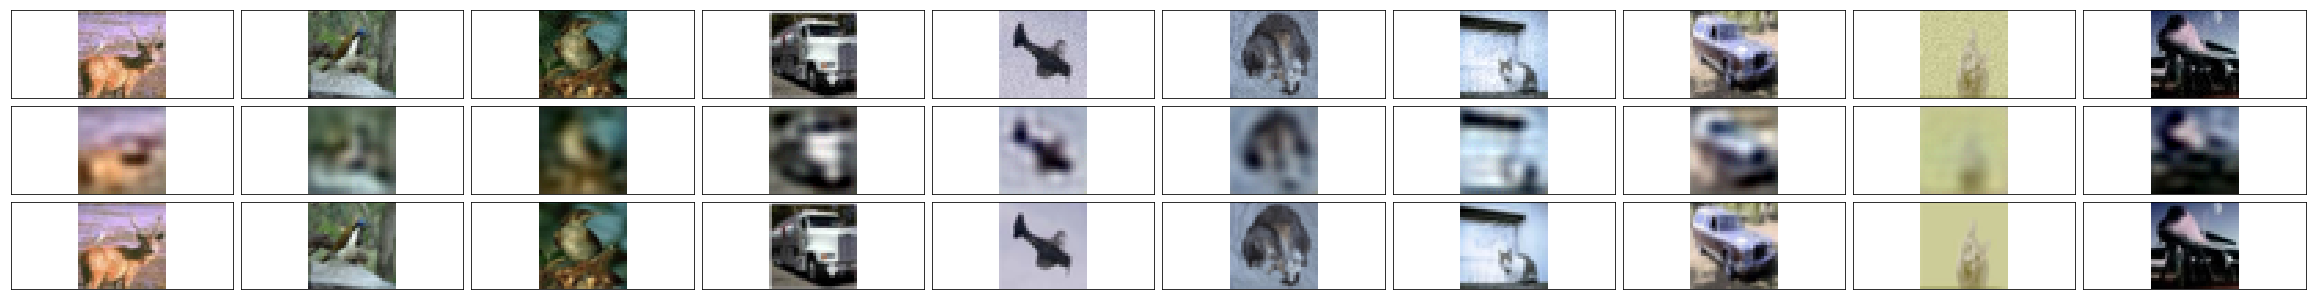

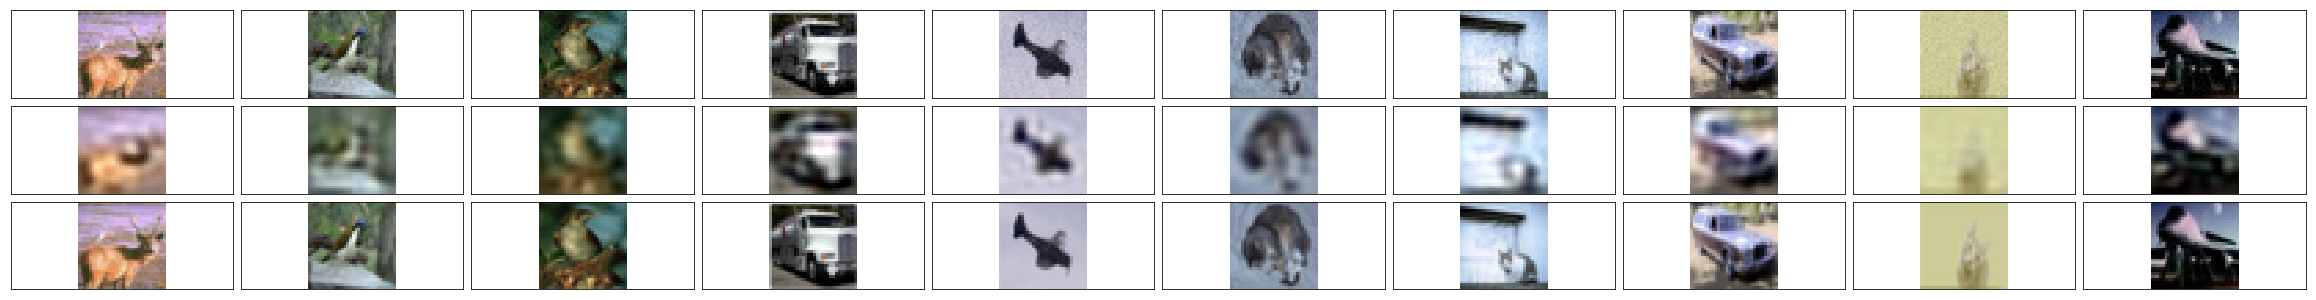

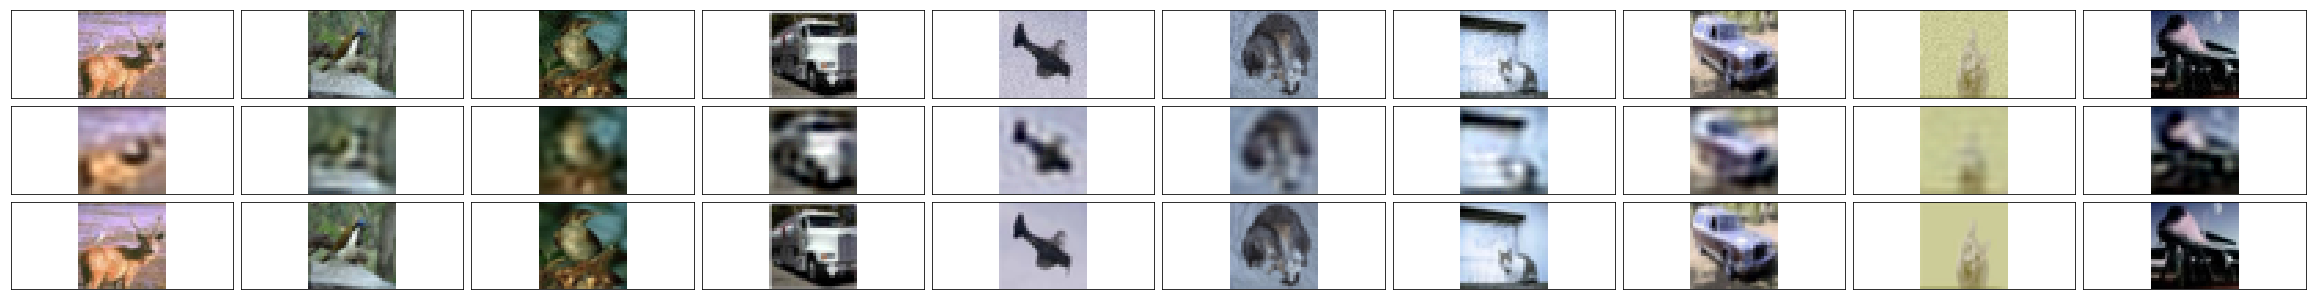

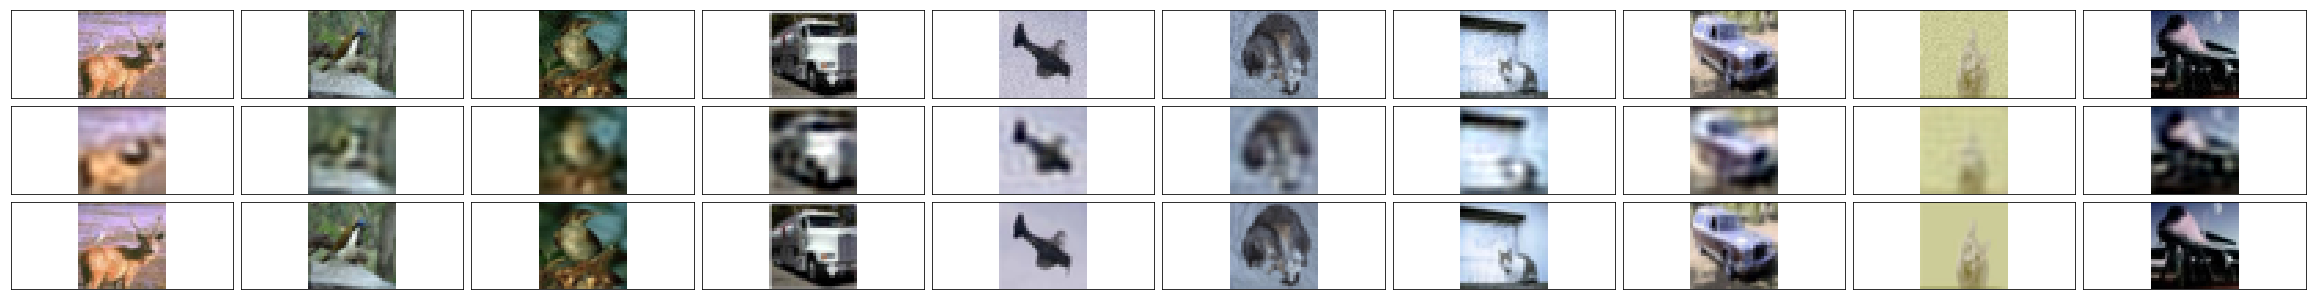

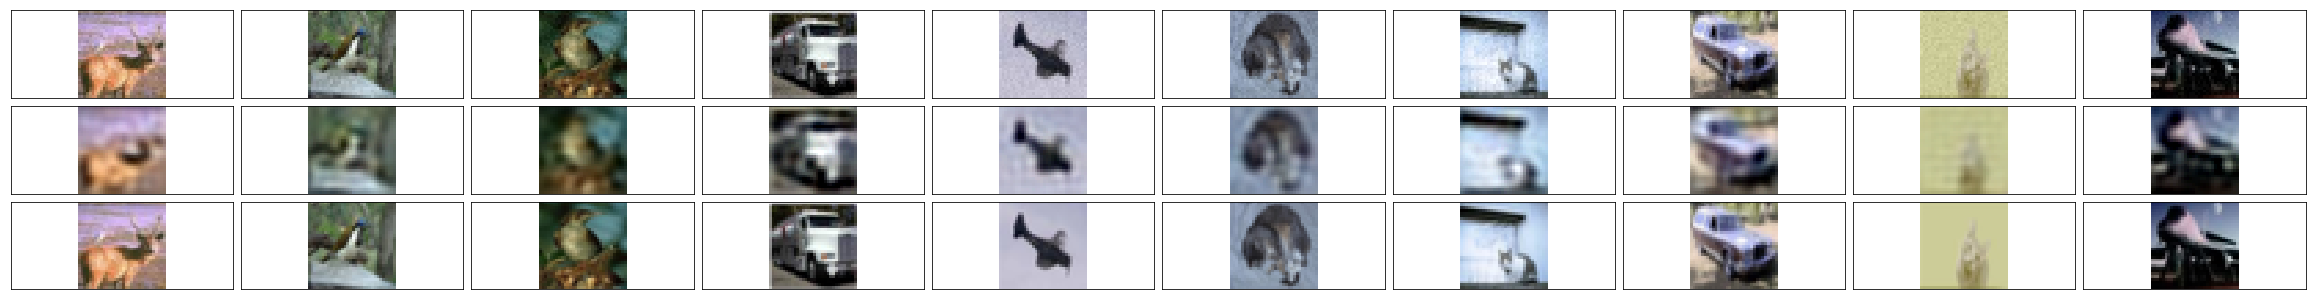

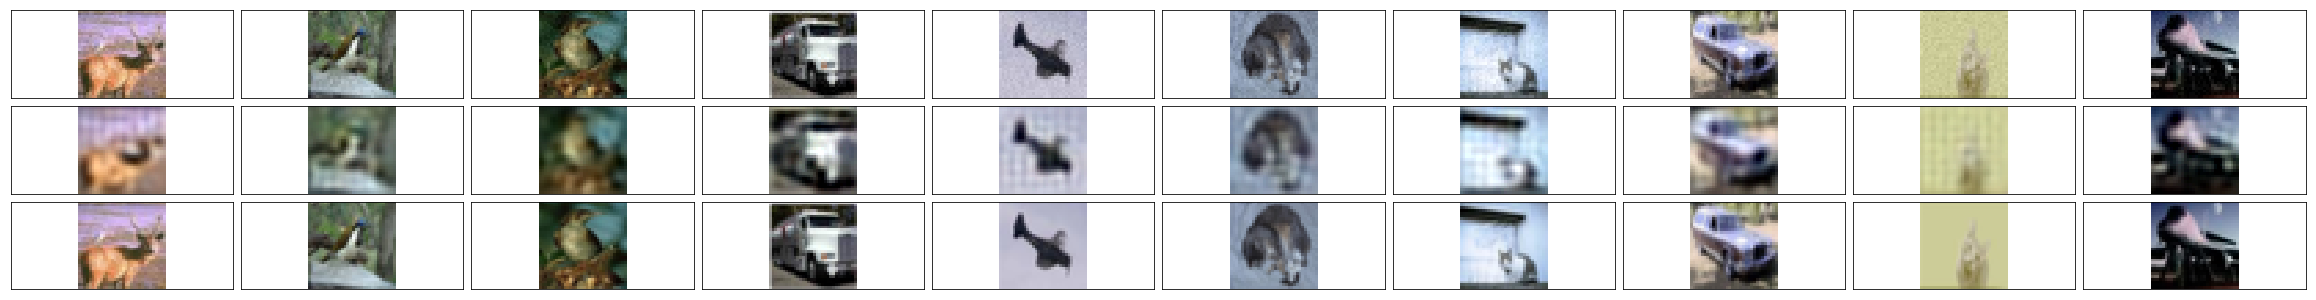

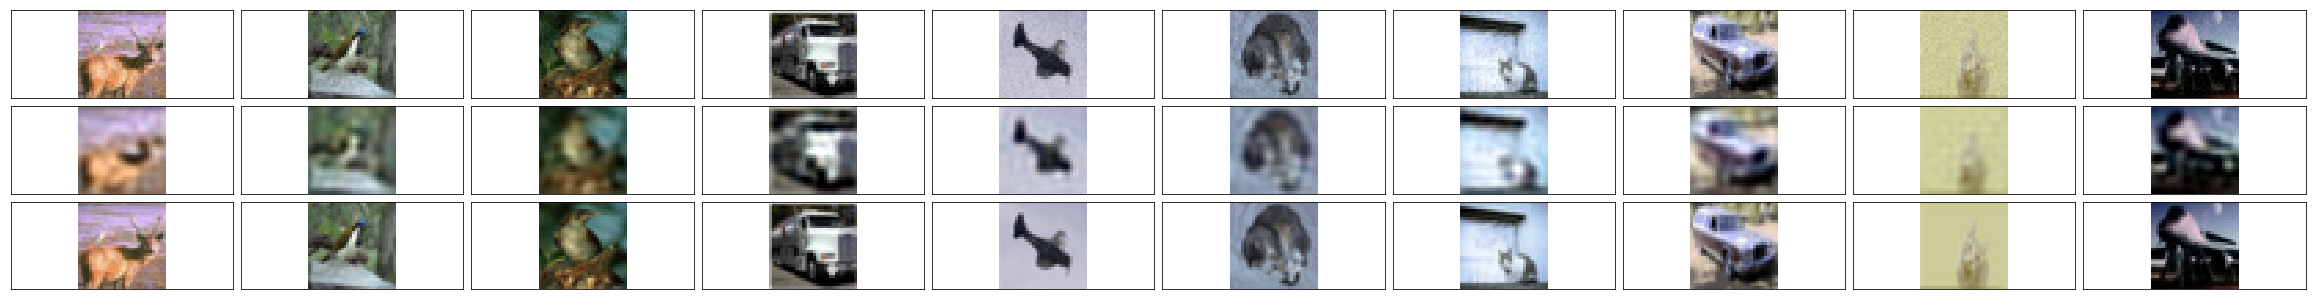

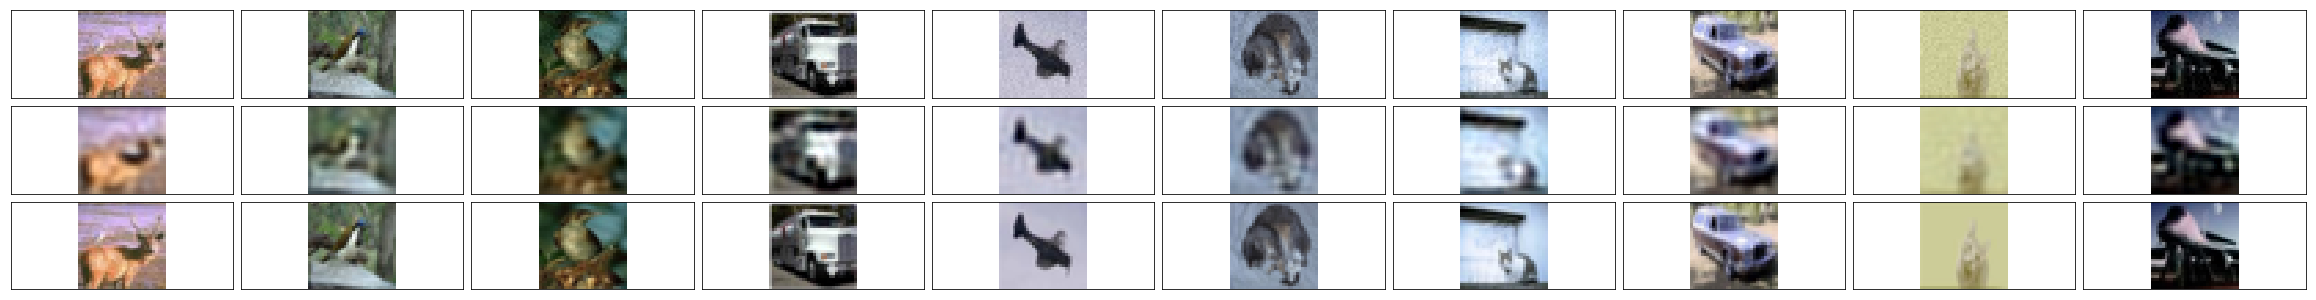

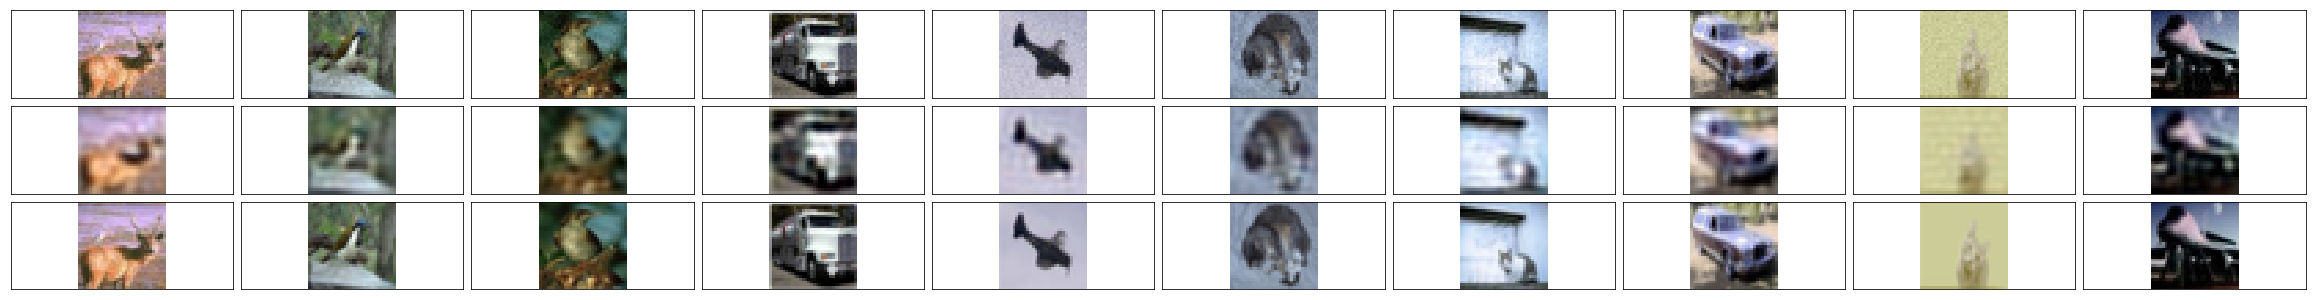

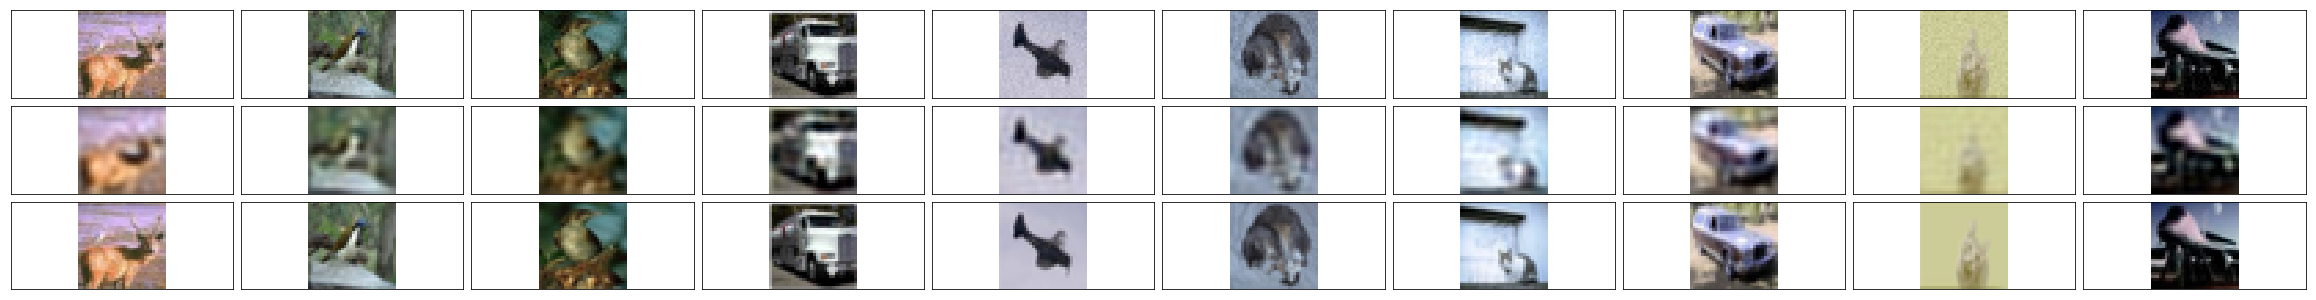

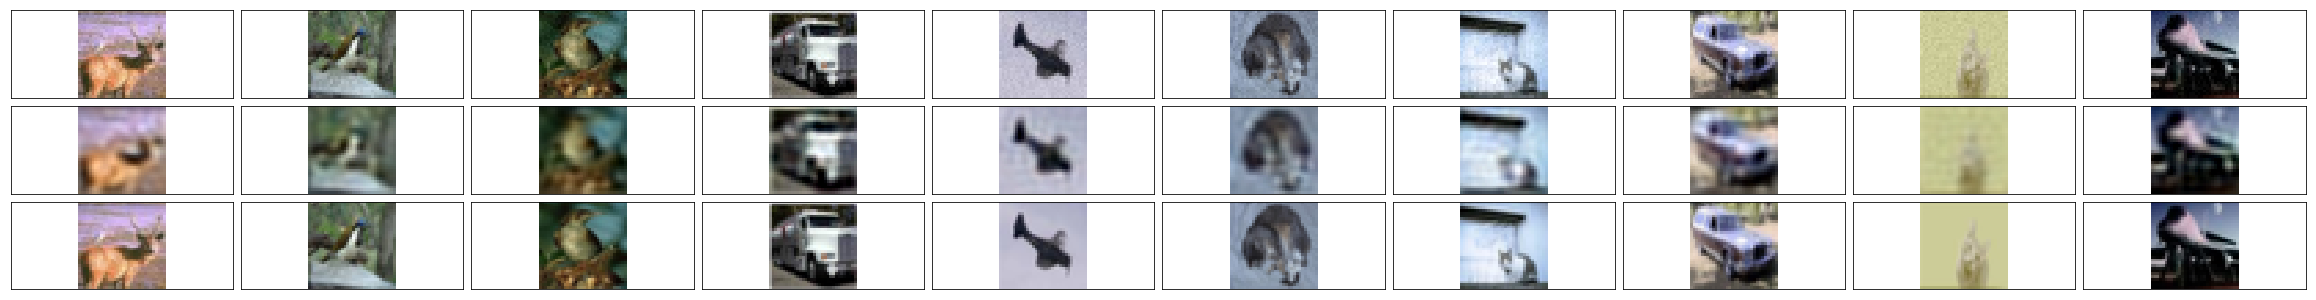

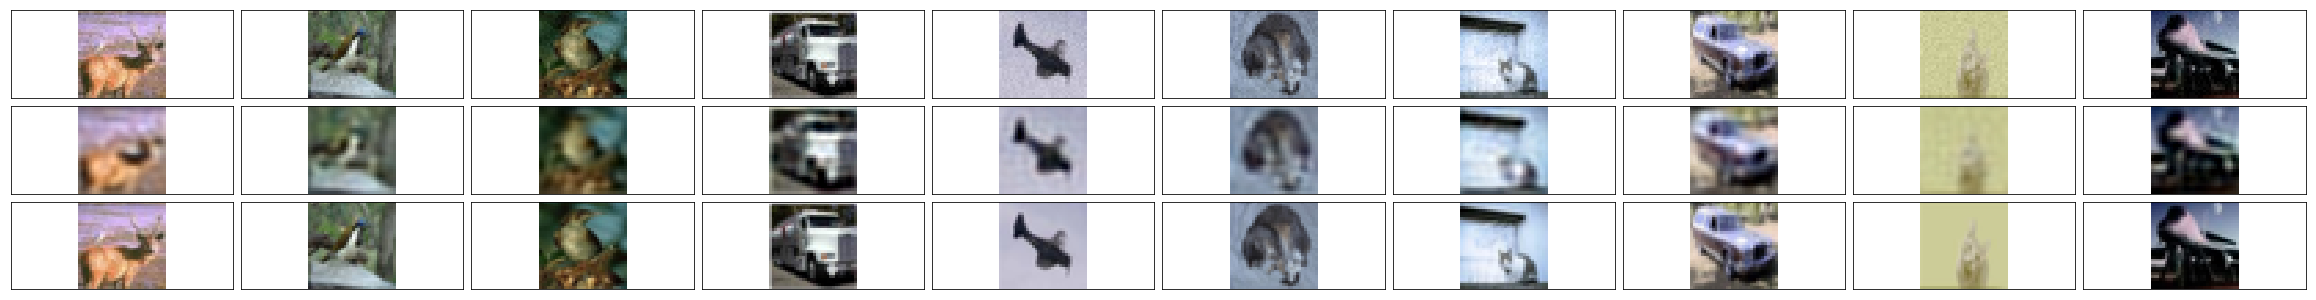

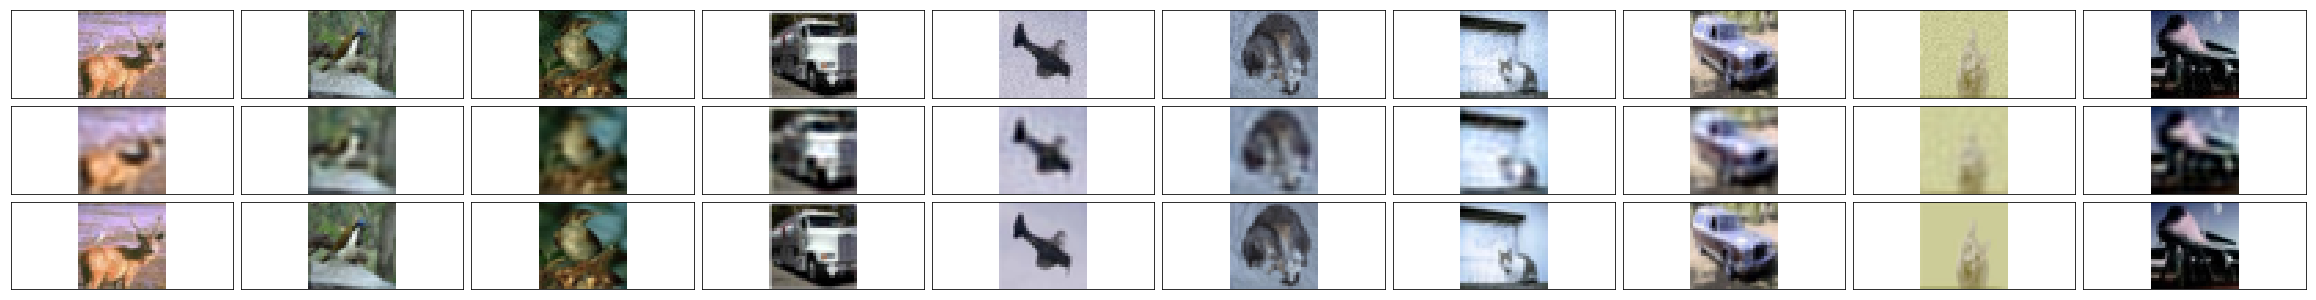

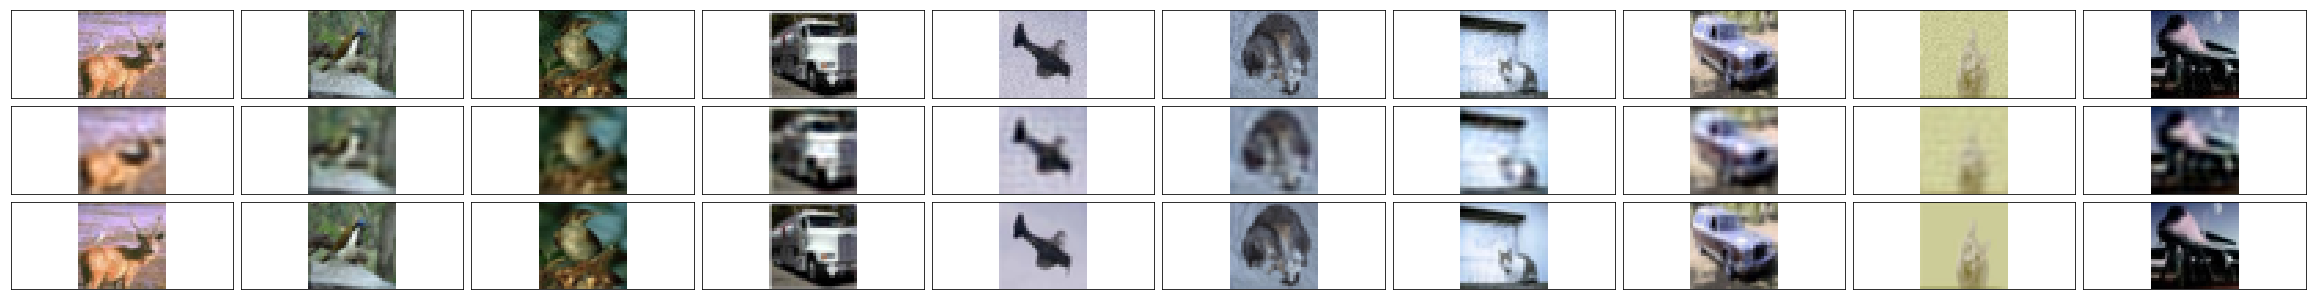

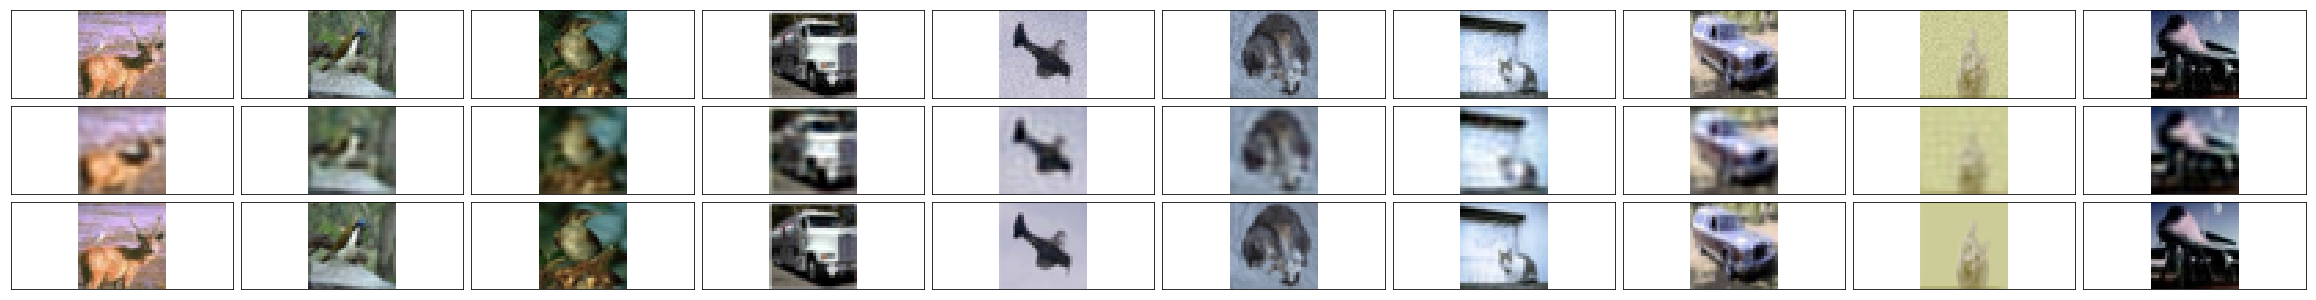

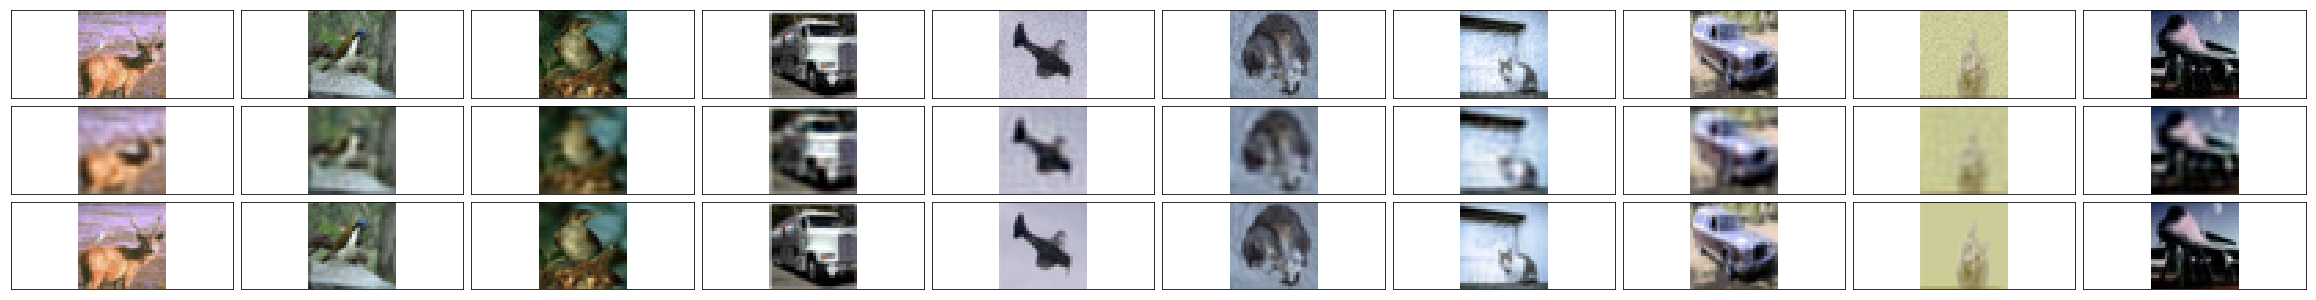

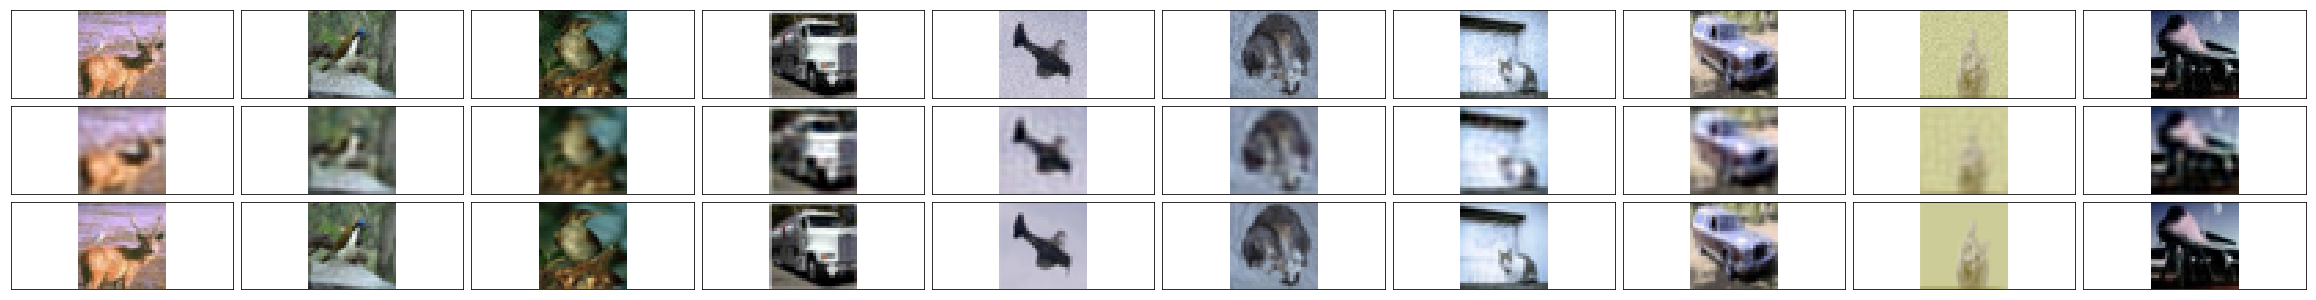

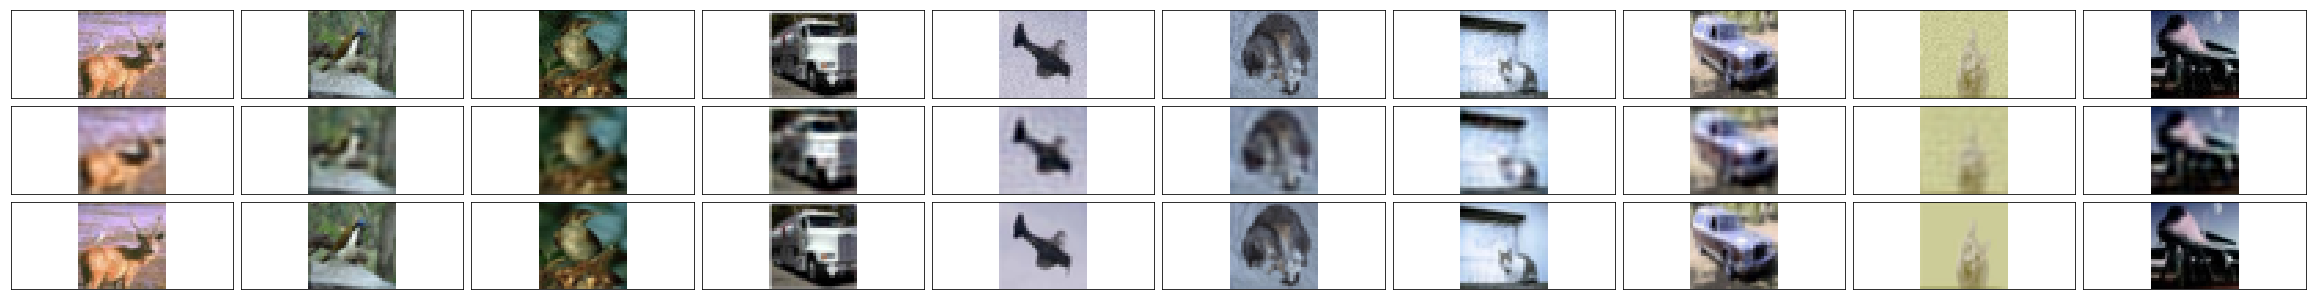

In [10]:
print('Training...')

sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for batch_i in range(1, N_BATCHES + 1):
        for features, noisy_features, _ in helper.load_preprocess_training_batch(batch_i, batch_size):
            batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_features, targets_: features})
            
    print("Epoch: {}/{}...".format(e + 1, epochs), "Training loss: {:.4f}".format(batch_cost))
    if e % show_images_every_n_epochs == 0:
        reconstructed = sess.run(y_pred, feed_dict={inputs_: valid_noisy[:10].reshape((10, 32, 32, 3))})
        helper.show_images(valid_features, valid_noisy, np.clip(reconstructed, 0, 1))

### Test the denoiser

Testing...


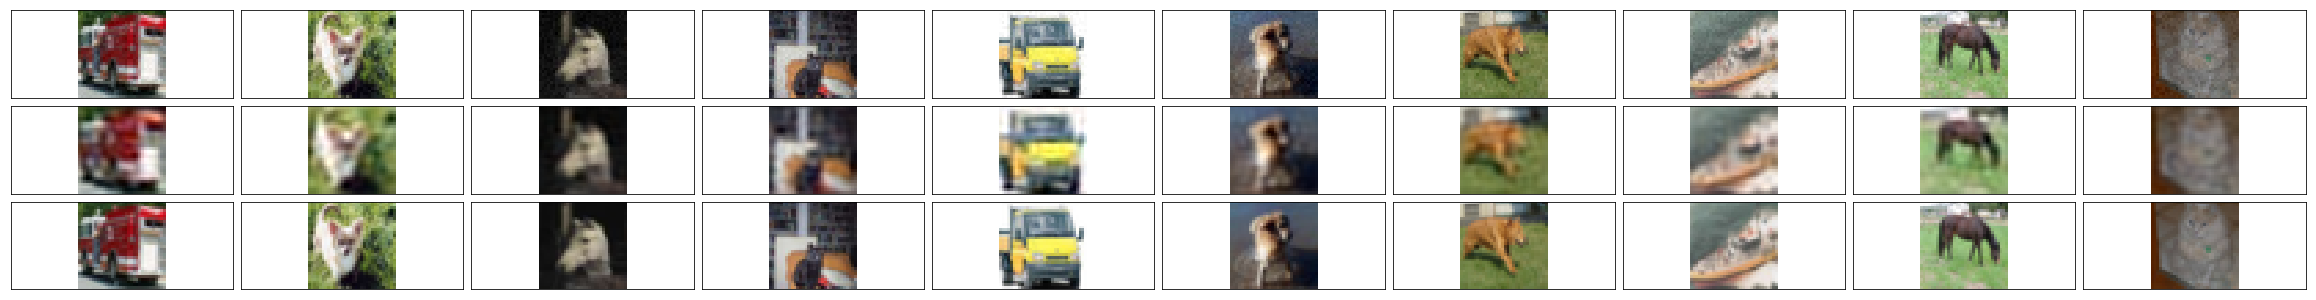

In [11]:
print('Testing...')

index = random.randint(0, len(test_features) - 10)

sample_test_features = test_features[index:index + 10]
sample_test_noisy = test_noisy[index:index + 10]

reconstructed = sess.run(y_pred, feed_dict={inputs_: sample_test_noisy.reshape((10, 32, 32, 3))})

helper.show_images(sample_test_features, sample_test_noisy, np.clip(reconstructed, 0, 1))

## Classifier

### Prepare the dataset

In [12]:
# use 20% of the dataset for training
helper.preprocess_and_save_data(CIFAR_10_DATASET_FOLDER_PATH, NOISE_FACTOR, int(N_BATCHES * 0.2))

valid_features, _, valid_labels = helper.load_preprocess_validation()

Preprocessing data...
Finished preprocessing


### Train the classifier

In [13]:
print('Training...')

for e in range(epochs):
    for features, _, labels in helper.load_preprocess_training_batch(1, batch_size):
        sess.run(classifier_opt, feed_dict={inputs_: features, labels_: labels, 
                                            keep_prob: keep_probability})
    helper.print_stats(e, sess, inputs_, features, labels_, labels, valid_features, valid_labels, 
                keep_prob, classifier_cost, accuracy)

Training...
Epoch  1:  
('cost: 2.0089', 'accuracy: 0.2930')
Epoch  2:  
('cost: 1.7368', 'accuracy: 0.3640')
Epoch  3:  
('cost: 1.6009', 'accuracy: 0.3950')
Epoch  4:  
('cost: 1.4847', 'accuracy: 0.4420')
Epoch  5:  
('cost: 1.3626', 'accuracy: 0.4550')
Epoch  6:  
('cost: 1.2554', 'accuracy: 0.4720')
Epoch  7:  
('cost: 1.1688', 'accuracy: 0.4880')
Epoch  8:  
('cost: 1.0679', 'accuracy: 0.5010')
Epoch  9:  
('cost: 0.9662', 'accuracy: 0.5170')
Epoch 10:  
('cost: 0.8934', 'accuracy: 0.5290')
Epoch 11:  
('cost: 0.7952', 'accuracy: 0.5240')
Epoch 12:  
('cost: 0.7407', 'accuracy: 0.5320')
Epoch 13:  
('cost: 0.6507', 'accuracy: 0.5300')
Epoch 14:  
('cost: 0.5799', 'accuracy: 0.5530')
Epoch 15:  
('cost: 0.5487', 'accuracy: 0.5380')
Epoch 16:  
('cost: 0.4971', 'accuracy: 0.5460')
Epoch 17:  
('cost: 0.4241', 'accuracy: 0.5600')
Epoch 18:  
('cost: 0.3525', 'accuracy: 0.5610')
Epoch 19:  
('cost: 0.3190', 'accuracy: 0.5390')
Epoch 20:  
('cost: 0.3073', 'accuracy: 0.5570')
Epoch 21

### Test the classifier

In [14]:
print('Testing...')

test_batch_acc_total = 0
test_batch_count = 0
for test_feature_batch, _, test_label_batch in helper.load_testing_batch(batch_size):
    test_batch_acc_total += sess.run(accuracy, feed_dict={inputs_: test_feature_batch, 
                                                          labels_: test_label_batch, keep_prob: 1.0})
    test_batch_count += 1

print("Testing Accuracy: {:.2f}".format(test_batch_acc_total / test_batch_count))

Testing...
Testing Accuracy: 0.57
